# Gradient Boosting

The next classification model we will investigate is the Gradient Boosting Classifier.

## Importing the libraries

In [2]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For creating the model
from sklearn.ensemble import GradientBoostingClassifier

#For evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score

In [4]:
import pickle

#Loading the training and test splits from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

## Importing the splits

In [5]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [6]:
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

## Initial Model

Here, we'll create an initial classification model using the GradientBoostingClassifier function from scikit-learn and test it on our splits.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


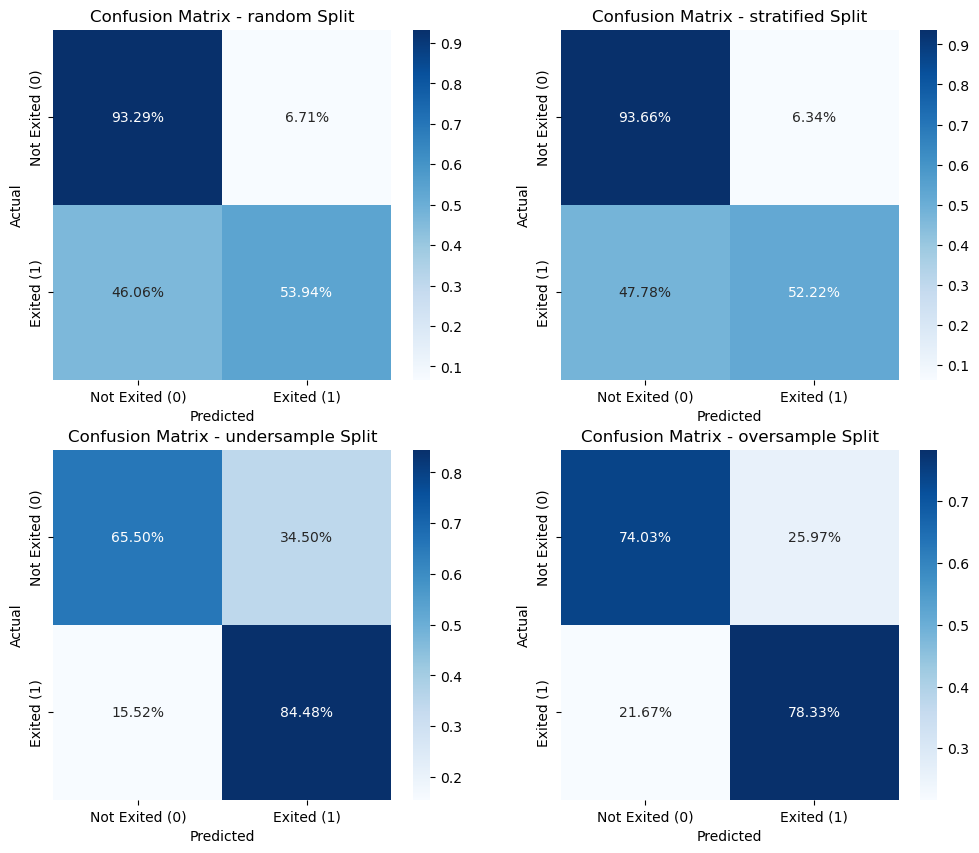

<Figure size 800x600 with 0 Axes>

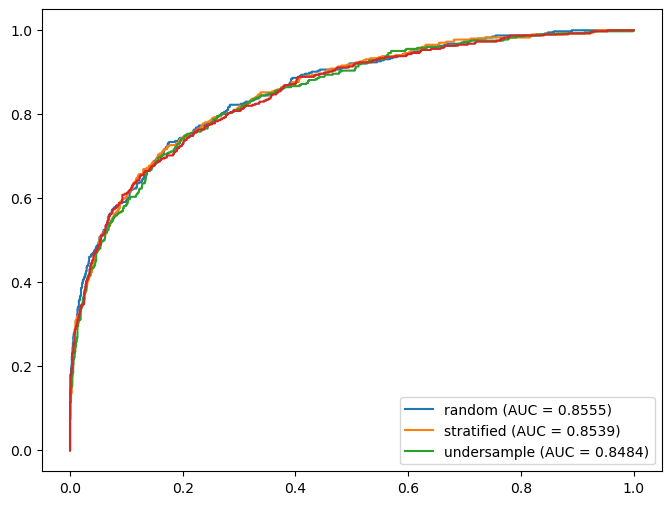

In [134]:
#We now need to create our Gradient Boosting Classification model

model = GradientBoostingClassifier(random_state=0)

#Create somewhere to store the performance metrics
performance ={}

def evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance):

    #Creating 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))

    #ROC Curve Figure
    plt.figure(figsize=(8,6))

    #Fit model for each of the 4 splits
    for idx, split in enumerate(split_data):

        X_train, X_val, y_train, y_val =split_data[split]
    
        #Train model
        model.fit(X_train, y_train)
    
        #Predict on validation set
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        #Predict on unseen test set
        y_test_pred = model.predict(X_test_raw)
        test_accuracy = accuracy_score(y_test_raw, y_test_pred)

        #Get general classification report
        test_report = classification_report(y_val, y_val_pred, output_dict = True)

        #Balanced accuracy, precision, recall, and F1-score for class 1 (positive class)
        precision = test_report['1']['precision']
        recall = test_report['1']['recall']
        f1_score = test_report['1']['f1-score']
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)

        #Plot confusion matrix for test set
        conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        #Normalize the confusion matrix by the number of true samples per class to get the values of the confusion matrix as a percentage of the total and labelling
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[idx].set_title(f'Confusion Matrix - {split} Split')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xlabel('Predicted')

    
        #Plot ROC curve on the same figure for all splits
        y_test_pred_prob = model.predict_proba(X_test_raw)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
        roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
        plt.legend(loc="lower right")
        plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')


        #Define performance metrics
        performance[split] = {
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'test_precision_1': precision,
            'test_recall_1': recall,
            'test_f1_score_1': f1_score,
            'false_positives': fp,
            'false_negatives': fn,
            'balanced_accuracy': balanced_acc
        }

    #Show the plots
    plt.show()
    return performance_matrix  

performance = evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance)
    

We can see from the ROC curve that the model performs well on all splits, particularly on the oversample and undersample splits. This is to be expected due to the nature of the dataset we're considering as it is imbalanced and the over/undersampling accounts for this.

In the context of our problem, we're interested in getting a high Recall value from our models, since we want to make sure we identify the customers who are going to churn so that the bank can put retention methods in place. 

The effects of the imbalanced dataset can be seen when it comes to the Recall of the random and stratified splits. In both these cases, the make-up of the data in the validation and test sets is expected to be very similar to that of the full dataset. Therefore, when training our model it doesn't have much information to go off when it comes to the predicting those who will churn, since a significantly smaller number of those in our data do churn.

On the contrary, oversampling and undersampling generate balanced test sets and assist model performance leading to the improved performance we can see above. The Recall value in undersampling and oversampling are of a satisfactory level.

In terms of accuracy, the initial Gradient Boosting Classifier model outperforms the baseline on both fronts.

In the following, we'll attempt to refine and improve the model by adjusting the parameters.

In [135]:
performance_df = pd.DataFrame(performance).T

In [136]:
performance_df

,val_accuracy,test_accuracy,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.851875,0.8530,0.759358,0.425150,0.545106,107.0,187.0,0.694802
stratified,0.871250,0.8525,0.794118,0.496933,0.611321,101.0,194.0,0.731983
undersample,0.785000,0.6935,0.489960,0.730539,0.586538,550.0,63.0,0.764954
oversample,0.790000,0.7490,0.497788,0.673653,0.572519,414.0,88.0,0.747174


## Parameter Tuning

For efficiency reasons, we will use Randomized Search Cross Validation in order to help optimise the parameters of our model. We prefer this to Grid Search Cross Validation as opposed to testing every combination of parameters, it randomly selects them and therefore runs in a fraction of the time.

We'll start by seeing what parameters are currently at play in our model.

In [137]:
#look at the parameters used by our gradient boosting classifier
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

We then commence the randomised search to find better parameters.

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

random_search = RandomizedSearchCV(GradientBoostingClassifier(), param_dist, n_iter=10, cv=5, scoring='recall')
random_search.fit(X_train, y_train)

print(f'Best Parameters: {random_search.best_params_}')


Best Parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2}


We will now run a model with these parameters

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2} 0.9909892262487757


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


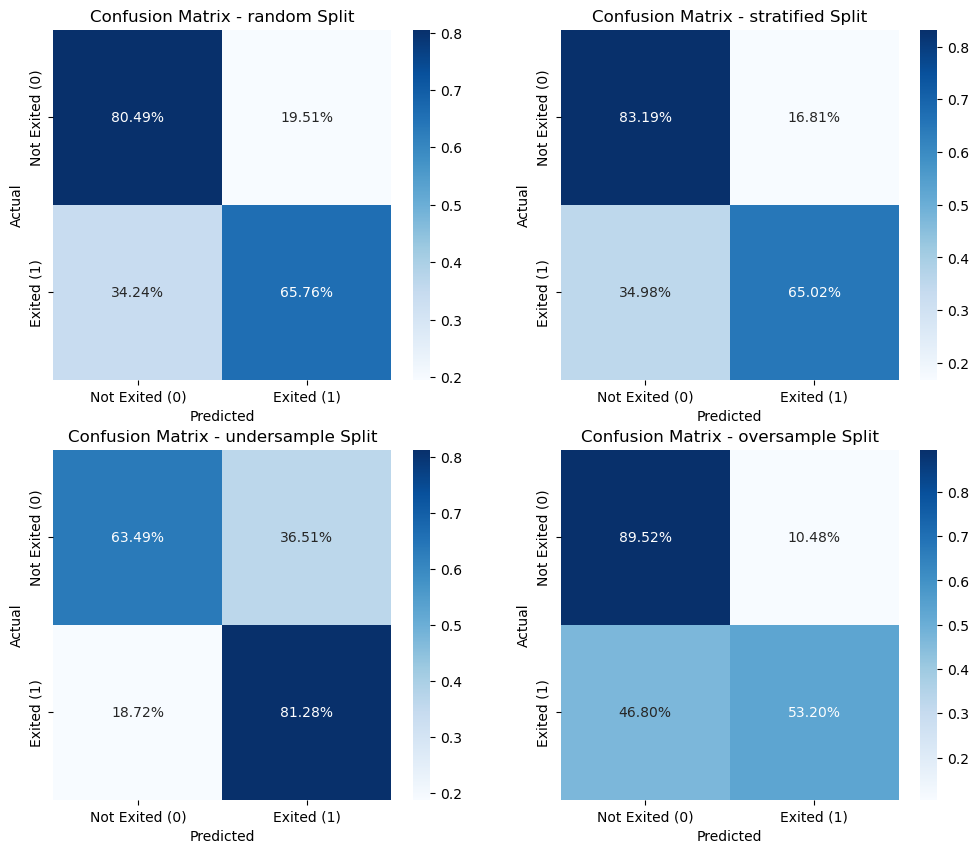

<Figure size 800x600 with 0 Axes>

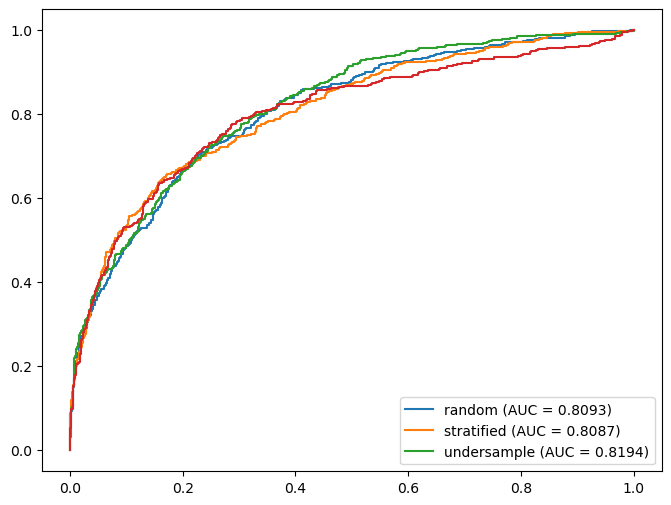

In [138]:
best_params = random_search.best_params_
best_score = random_search.best_score_
print(best_params, best_score)

best_model = GradientBoostingClassifier(**best_params,random_state=0)
performance_best = {}
performance_best = evaluating_performance_diff_splits(model=best_model,split_data=split_data,performance_matrix=performance_best)


In [139]:
print(performance_best)

{}


In [140]:
best_performance_df = pd.DataFrame(performance_best).T
best_performance_df

""


This has made our model worse.